In [1]:
import sys
# load standard python modules
import os
import numpy as np
import matplotlib.pyplot as plt
import random
import time
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

plt.style.use("science.mplstyle")

from matplotlib.backends.backend_pdf import PdfPages

# load torch modules
import torch
import torch.nn as nn
import torch.nn.functional as F

from modules.file_readers import phi_wrap, pandas_to_unclustered_particles, get_highest_mass_constituents, pandas_to_features, select_jets_1, select_jets_2 
from modules.jet_visualizers import plot_jets_phase_plane, plot_nsubs
from modules.jet_augs import apply_single_jet_augs, translate_jets, rotate_jets, rescale_pts, distort_jets, collinear_fill_jets, crop_jets
from modules.jet_vars import nsub, convert_constits_coords


In [2]:
# choose from: "02092021", "dijet"

study_type = "dijet"

path_to_unclustered = "/clusterfs/ml4hep/rrmastandrea/LHC0/events_anomalydetection.h5"
path_to_data_storage = "/clusterfs/ml4hep/rrmastandrea/processed_data/"+"final_16_02_2022"+"/"


# Load in the data

Starts with a dataset of particles $p_T$, $\eta$, $\phi$

Clusters into jets, takes highest mass jet, returns the constituents ordered by pT

Dataset shape: (n,3,101) = (n,[$p_T$, $\eta$, $\phi$],1 jet + 100 constituents)

In [3]:
clustered_npy_exists = True

    
if clustered_npy_exists: 
    
    jetR = 0.8
    
    j_per_e = 2
    center = "J1_phi_only_pi_2"
    
    
    if study_type == "dijet":
    
       
        delta = 10000
        high_mass_consits_wjet = np.load(path_to_data_storage+"dijet_data_jetR_"+str(jetR)+"_"+center+"_"+str(0)+"_"+str(delta)+".npy")
        high_mass_labels = np.load(path_to_data_storage+"dijet_labels_jetR_"+str(jetR)+"_"+center+"_"+str(0)+"_"+str(delta)+".npy")

        for start in range(10000,1100000-delta,delta):

            stop = start + delta
                        

            high_mass_consits_wjet = np.concatenate([high_mass_consits_wjet, np.load(path_to_data_storage+"dijet_data_jetR_"+str(jetR)+"_"+center+"_"+str(start)+"_"+str(stop)+".npy")])
            high_mass_labels = np.concatenate([high_mass_labels, np.load(path_to_data_storage+"dijet_labels_jetR_"+str(jetR)+"_"+center+"_"+str(start)+"_"+str(stop)+".npy")])

    
    print("Read in files")
    print("Data shape: ",high_mass_consits_wjet.shape)
    print("Labels shape:", high_mass_labels.shape)
          

Read in files
Data shape:  (1089948, 3, 102)
Labels shape: (1089948,)


## Jet cuts 

Cut on $p_t$, $\eta$ of the jets 

Then split into signal and background datasets

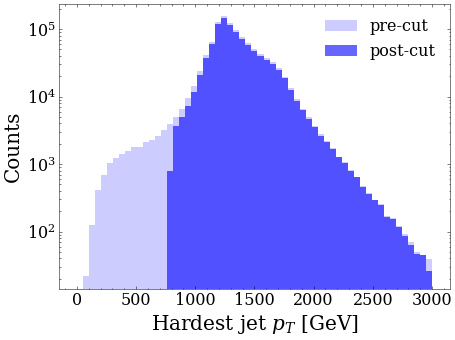

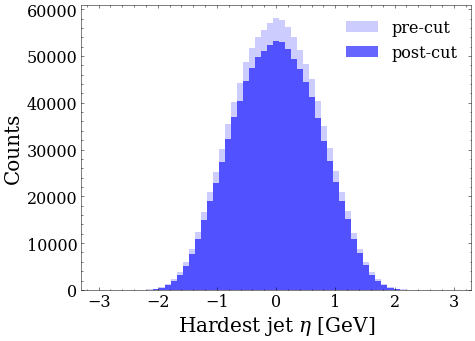

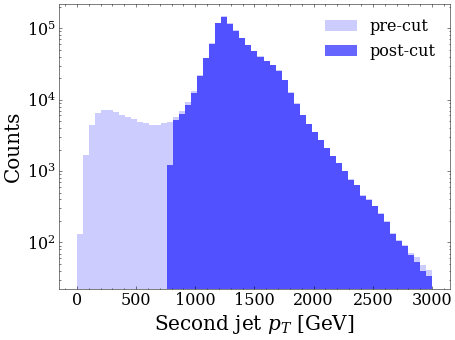

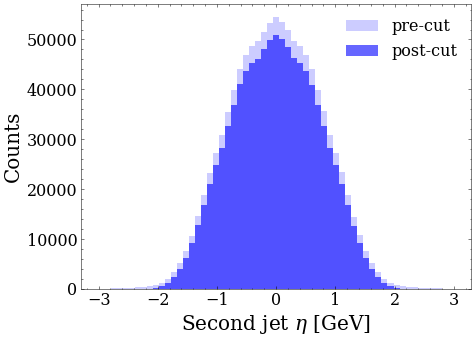

In [4]:
# Select jets of interest

# pT, eta cuts
pt_cut_0 = [800,3000]
eta_cut_0 = [-3,3]
pt_cut_1 = [800,3000]
eta_cut_1 = [-3,3]


n_const = 50
high_mass_consits_wjet_cut, high_mass_labels_cut = select_jets_2(high_mass_consits_wjet, high_mass_labels, n_const, pt_cut_0, pt_cut_1, eta_cut_0, eta_cut_1)


def plot_pre_post(pre_dist, post_dist, bins, xlabel, logy = False):
    fig = plt.figure()
    
    plt.hist(pre_dist, bins = bins, alpha = 0.2, label = "pre-cut", color = "blue")
    plt.hist(post_dist, bins = bins, alpha = 0.6, label = "post-cut", color = "blue")
    plt.legend()
    plt.xlabel(xlabel)
    plt.ylabel("Counts")
    if logy:
        plt.yscale("log")
    
    fig.show()
    
    return fig


img_name = "figures/hardest_pT_pre_post_cut.pdf"
pp = PdfPages(img_name)
fig = plot_pre_post(high_mass_consits_wjet[:,0,0], high_mass_consits_wjet_cut[:,0,0], 
                   np.linspace(0,3000,60), "Hardest jet $p_T$ [GeV]", True)
pp.savefig(fig)
pp.close()

img_name = "figures/hardest_eta_pre_post_cut.pdf"
pp = PdfPages(img_name)
fig = plot_pre_post(high_mass_consits_wjet[:,1,0], high_mass_consits_wjet_cut[:,1,0], 
                   np.linspace(-3,3,60), "Hardest jet $\eta$ [GeV]")
pp.savefig(fig)
pp.close()

img_name = "figures/second_pT_pre_post_cut.pdf"
pp = PdfPages(img_name)
fig = plot_pre_post(high_mass_consits_wjet[:,0,n_const+1], high_mass_consits_wjet_cut[:,0,n_const+1], 
                   np.linspace(0,3000,60), "Second jet $p_T$ [GeV]", True)
pp.savefig(fig)
pp.close()

img_name = "figures/second_eta_pre_post_cut.pdf"
pp = PdfPages(img_name)
fig = plot_pre_post(high_mass_consits_wjet[:,1,n_const+1], high_mass_consits_wjet_cut[:,1,n_const+1], 
                   np.linspace(-3,3,60), "Second jet $\eta$ [GeV]")
pp.savefig(fig)
pp.close()





# Last data preprocessing

-- removing the jet from the jet + constituents array

-- rescaling the pt

-- splitting into signal vs background

-- crop the jets

-- adding zero pad for collinear splitting

In [5]:
def zero_pad_consts(data, n):
        zero_pad = np.zeros((data.shape[0],3,n-data.shape[2]))
        data = np.concatenate((data,zero_pad), axis = 2)
        return data

j_per_e  = 2

print("Initial array shape:", high_mass_consits_wjet_cut.shape)

# split the event into the jets
split_jets = np.split(high_mass_consits_wjet_cut, j_per_e, axis = 2)
modified_jets = []

# now go through each jet
for i, subjet in enumerate(split_jets):
    print("On jet", i)
    
    # Take only the constituents (i.e. drop the 0th, which is the jet)
    #subjet = subjet[:,:,1:]
    
    # crop the n constituents
    n_nonzero_conts = 50
    print("Cropping the jets to",n_nonzero_conts,"consituents")
    subjet = crop_jets(subjet,1+n_nonzero_conts)
    
    # add zero pad
    n_zero_pad = 0
    print("Adding a zero pad of size", n_zero_pad)
    subjet = zero_pad_consts(subjet,n_zero_pad+n_nonzero_conts+1)
    
    modified_jets.append(subjet)
    print()
    
# recombine the jets
high_mass_consits = np.concatenate(modified_jets, axis = 2)
print("Final array shape:", high_mass_consits.shape)
print()


high_mass_consits_sig = high_mass_consits[np.where(high_mass_labels_cut==1)]
high_mass_consits_bkg = high_mass_consits[np.where(high_mass_labels_cut==0)]


print("Signal shape:", high_mass_consits_sig.shape)
print("Background shape:", high_mass_consits_bkg.shape)



Initial array shape: (993473, 3, 102)
On jet 0
Cropping the jets to 50 consituents
Adding a zero pad of size 0

On jet 1
Cropping the jets to 50 consituents
Adding a zero pad of size 0

Final array shape: (993473, 3, 102)

Signal shape: (95569, 3, 102)
Background shape: (897904, 3, 102)


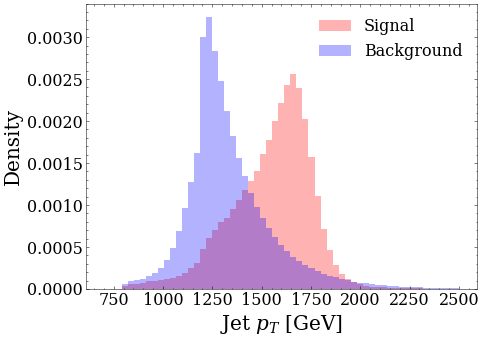

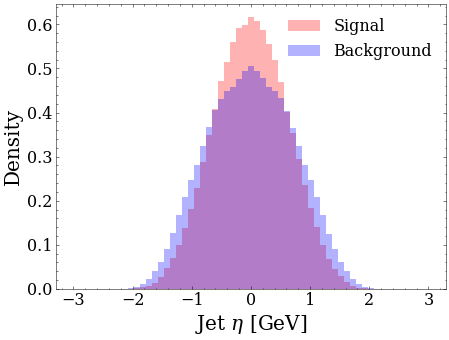

In [6]:
# Plotting jet pt, eta for signal vs background

def plot_S_B(S_dist, B_dist, bins, xlabel, logy = False):
    fig = plt.figure()
    
    plt.hist(S_dist, bins = bins, alpha = 0.3, label = "Signal", color = "red", density = True)
    plt.hist(B_dist, bins = bins, alpha = 0.3, label = "Background", color = "blue", density = True)
    plt.legend()
    plt.xlabel(xlabel)
    plt.ylabel("Density")
    if logy:
        plt.yscale("log")
    
    fig.show()
    
    return fig


sig_to_plot_pt = np.concatenate((high_mass_consits_sig[:,0,0],high_mass_consits_sig[:,0,n_const+1]))
bkg_to_plot_pt = np.concatenate((high_mass_consits_bkg[:,0,0],high_mass_consits_bkg[:,0,n_const+1]))

sig_to_plot_eta = np.concatenate((high_mass_consits_sig[:,1,0],high_mass_consits_sig[:,1,n_const+1]))
bkg_to_plot_eta = np.concatenate((high_mass_consits_sig[:,1,0],high_mass_consits_bkg[:,1,n_const+1]))



img_name = "figures/S_B_pT.pdf"
pp = PdfPages(img_name)
fig = plot_S_B(sig_to_plot_pt, bkg_to_plot_pt, 
                   np.linspace(700,2500,60), "Jet $p_T$ [GeV]")
pp.savefig(fig)
pp.close()

img_name = "figures/S_B_eta.pdf"
pp = PdfPages(img_name)
fig = plot_S_B(sig_to_plot_eta, bkg_to_plot_eta, 
                   np.linspace(-3,3,60), "Jet $\eta$ [GeV]")
pp.savefig(fig)
pp.close()




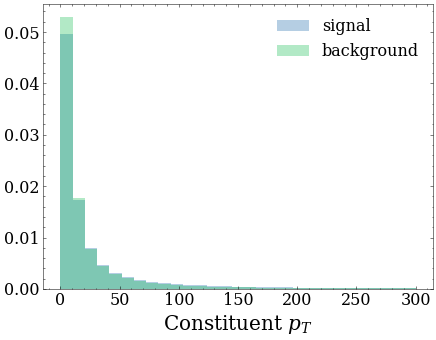

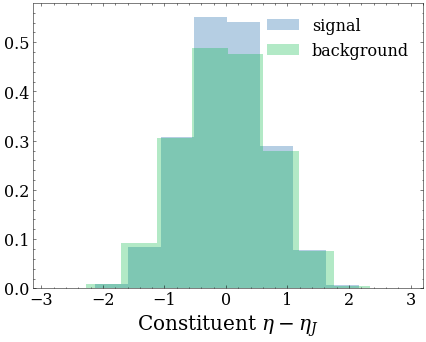

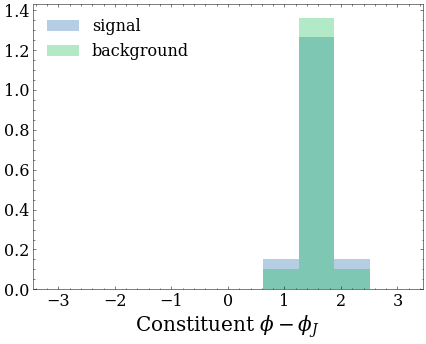

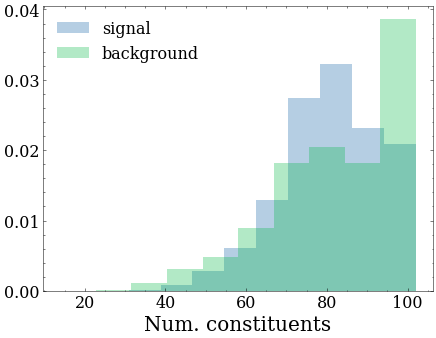

In [7]:
# THIS IS WRONG AS IT INCUDES THE JET



# Plots of pt, eta, phi for the constituents

N_start = 0  # Number of collision events
N_stop = 700000

M = 51  # Number of constituents


plt.figure()
loc_plot = np.reshape(high_mass_consits_sig[N_start:N_stop,0,1:M],((N_start-N_stop)*(M),))
plt.hist(loc_plot[loc_plot != 0]/1.0, bins = np.linspace(0,300,30), alpha = .3, density=True, label = "signal")
loc_plot = np.reshape(high_mass_consits_bkg[N_start:N_stop,0,1:M],((N_start-N_stop)*(M),))
plt.hist(loc_plot[loc_plot != 0]/1.0, bins = np.linspace(0,300,30), alpha = .3, density=True, label = "background")
plt.xlabel("Constituent $p_T$")
#plt.xlim(0,5000)
plt.legend()
plt.show()


plt.figure()
loc_plot = np.reshape(high_mass_consits_sig[N_start:N_stop,1,0:M],((N_start-N_stop)*(M),))
plt.hist(loc_plot[loc_plot != 0], alpha = .3, density=True, label = "signal")
loc_plot = np.reshape(high_mass_consits_bkg[N_start:N_stop,1,0:M],((N_start-N_stop)*(M),))
plt.hist(loc_plot[loc_plot != 0], alpha = .3, density=True, label = "background")
plt.xlabel("Constituent $\eta-\eta_J$")
plt.legend()
plt.show()


plt.figure()
loc_plot = np.reshape(high_mass_consits_sig[N_start:N_stop,2,0:M],((N_start-N_stop)*(M),))
plt.hist(loc_plot[loc_plot != 0], alpha = .3, density=True, label = "signal")
loc_plot = np.reshape(high_mass_consits_bkg[N_start:N_stop,2,0:M],((N_start-N_stop)*(M),))
plt.hist(loc_plot[loc_plot != 0], alpha = .3, density=True, label = "background")
plt.xlabel("Constituent $\phi-\phi_J$")
plt.legend()
plt.show()


# Plot num constituents

def get_num_constits(dataset):
    consits_list = []
    for collision in dataset:
        pts = collision[0,:]

        pads = np.where(pts==0)
        consits_list.append(dataset.shape[2]-len(pads[0]))
        
    return consits_list
        

plt.figure()
plt.hist(get_num_constits(high_mass_consits_sig), alpha = .3, density=True, label = "signal")
plt.hist(get_num_constits(high_mass_consits_bkg), alpha = .3, density=True, label = "background")
plt.xlabel("Num. constituents")
plt.legend()
plt.show()





# Split the data into test / train / validation sets

- CLR training: First ```num_clr_train``` background events
- CLR val: 20% of CLR train

- Classification training: (up to) ```njets_sig``` signal, ```njets_bkg``` background
- Classification test: 30% of training
- Classification test is further split into validation / test

** MUST start at 10k events in to avoid overlap with the standard test set **

Note: we change the S/B ratio for the CLR training ONLY



In [8]:
#"""
#"""
# STANDARD TEST SET
#"""
#"""


sts_end = 10000

dataset_sample_sig = high_mass_consits_sig[0:sts_end,:,:]
dataset_sample_bkg = high_mass_consits_bkg[0:sts_end,:,:]


data_test = np.concatenate([dataset_sample_sig,dataset_sample_bkg])
labels_test = np.concatenate([np.ones(dataset_sample_sig.shape[0]),np.zeros(dataset_sample_bkg.shape[0])])
data_test, labels_test = shuffle(data_test, labels_test)

print( "Standard test data shape: " + str( data_test.shape ), flush=True)
print( "Standard test labels shape: " + str( labels_test.shape ), flush=True)

path_to_save_dir = "/global/home/users/rrmastandrea/training_data_vf/"

save_id = "STANDARD_TEST_SET_n_sig_10k_n_bkg_10k"+"_n_nonzero_"+str(n_nonzero_conts)+"_n_pad_"+str(n_zero_pad)+"_n_jet_"+str(j_per_e)+"/"

path_to_save_dir += save_id
print(path_to_save_dir)

if os.path.isdir(path_to_save_dir):
    print("ERROR: experiment already exists, don't want to overwrite it by mistake")
    pass
else:
    os.makedirs(path_to_save_dir)
    
np.save(path_to_save_dir+"data.npy",data_test)
np.save(path_to_save_dir+"labels.npy",labels_test)

#"""

Standard test data shape: (20000, 3, 102)
Standard test labels shape: (20000,)
/global/home/users/rrmastandrea/training_data_vf/STANDARD_TEST_SET_n_sig_10k_n_bkg_10k_n_nonzero_50_n_pad_0_n_jet_2/


In [10]:
#"""
#"""
# CLR TRAIN / VAL
#"""
#"""

n_constits_max = n_nonzero_conts

"""
RUN THE JET SELECTOR CODE
"""

t0 = time.time()


num_clr_train_sig = 10000
num_clr_train_bkg = 10000
val_size = 0.3

dataset_clr_sig = high_mass_consits_sig[sts_end:num_clr_train_sig+sts_end,:,:]
dataset_clr_bkg = high_mass_consits_bkg[sts_end:num_clr_train_bkg+sts_end,:,:]

print("Num signal:", dataset_clr_sig.shape[0],"; Num background:", dataset_clr_bkg.shape[0])


# split into train - val
((clr_sig_train, clr_sig_val),
 (clr_bkg_train, clr_bkg_val),
 ) = [train_test_split(arr, test_size=val_size) for arr in [
    dataset_clr_sig,
    dataset_clr_bkg,
]]

# preparing the training dataset w/ labels
#clr_train = np.concatenate([clr_sig_train,clr_bkg_train])
clr_train = np.concatenate([clr_bkg_train])
clr_train = shuffle(clr_train)

# preparing the test dataset(s)
#clr_val = np.concatenate([clr_sig_val,clr_bkg_val])
clr_val = np.concatenate([clr_bkg_val])
clr_val = shuffle(clr_val)


# print data dimensions
print( "CLR training data shape: " + str( clr_train.shape ), flush=True)
print( "CLR val data shape: " + str( clr_val.shape ), flush=True)

t1 = time.time()

print( "time taken to load and preprocess data: "+str( np.round( t1-t0, 2 ) ) + " seconds", flush=True  )
print()


n_sig_total = dataset_clr_sig.shape[0]
n_bkg_total = dataset_clr_bkg.shape[0]

path_to_save_dir = "/global/home/users/rrmastandrea/training_data_vf/"

save_id_dir = "nCLR_sig_"+str(n_sig_total)+"_nCLR_bkg_"+str(n_bkg_total)+"_n_nonzero_"+str(n_nonzero_conts)+"_n_pad_"+str(n_zero_pad)+"_n_jet_"+str(j_per_e)+"/"

path_to_save_dir += save_id_dir
print(path_to_save_dir)

if os.path.isdir(path_to_save_dir):
    print("ERROR: experiment already exists, don't want to overwrite it by mistake")
    pass
else:
    os.makedirs(path_to_save_dir)
    
np.save(path_to_save_dir+"clr_train.npy",clr_train)
np.save(path_to_save_dir+"clr_val.npy",clr_val)




Num signal: 10000 ; Num background: 10000
CLR training data shape: (7000, 3, 102)
CLR val data shape: (3000, 3, 102)
time taken to load and preprocess data: 0.03 seconds

/global/home/users/rrmastandrea/training_data_vf/nCLR_sig_10000_nCLR_bkg_10000_n_nonzero_50_n_pad_0_n_jet_2/


In [12]:
#"""
#"""
# BC TRAIN / VAL
#"""
#"""

t0 = time.time()


njets_sig = 85000
njets_bkg = 85000

# take only however many constituents and jets we want 
dataset_sample_sig = high_mass_consits_sig[sts_end:njets_sig+sts_end,:,:]
dataset_sample_bkg = high_mass_consits_bkg[sts_end:njets_bkg+sts_end,:,:]

print("Num signal:", dataset_sample_sig.shape[0],"; Num background:", dataset_sample_bkg.shape[0])

# split into train - val 
test_size = .3
((sig_train, sig_val),
 (bkg_train, bkg_val),
 ) = [train_test_split(arr, test_size=test_size) for arr in [
    dataset_sample_sig,
    dataset_sample_bkg,
]]


# preparing the training dataset w/ labels
data_train = np.concatenate([sig_train,bkg_train])
labels_train = np.concatenate([np.ones(sig_train.shape[0]),np.zeros(bkg_train.shape[0])])

#data_train = np.concatenate([bkg_train])
#labels_train = np.concatenate([np.zeros(bkg_train.shape[0])])

data_train, labels_train = shuffle(data_train, labels_train)

# preparing the test dataset(s)
data_val = np.concatenate([sig_val,bkg_val])
labels_val = np.concatenate([np.ones(sig_val.shape[0]),np.zeros(bkg_val.shape[0])])
#data_val = np.concatenate([bkg_val])
#labels_val = np.concatenate([np.zeros(bkg_val.shape[0])])

data_val, labels_val = shuffle(data_val, labels_val)



# print data dimensions
print( "BC training data shape: " + str( data_train.shape ), flush=True)
print( "BC training labels shape: " + str( labels_train.shape ), flush=True)
print( "BC val data shape: " + str( data_val.shape ), flush=True)
print( "BC val labels shape: " + str( labels_val.shape ), flush=True)


t1 = time.time()

print( "time taken to load and preprocess data: "+str( np.round( t1-t0, 2 ) ) + " seconds", flush=True  )
print()



n_sig_total = dataset_sample_sig.shape[0]
n_bkg_total = dataset_sample_bkg.shape[0]


path_to_save_dir = "/global/home/users/rrmastandrea/training_data_vf/"

save_id_dir = "nBC_sig_"+str(n_sig_total)+"_nBC_bkg_"+str(n_bkg_total)+"_n_nonzero_"+str(n_nonzero_conts)+"_n_pad_"+str(n_zero_pad)+"_n_jet_"+str(j_per_e)+"/"

path_to_save_dir += save_id_dir
print(path_to_save_dir)

if os.path.isdir(path_to_save_dir):
    print("ERROR: experiment already exists, don't want to overwrite it by mistake")
    pass
else:
    os.makedirs(path_to_save_dir)
    

np.save(path_to_save_dir+"data_train.npy",data_train)
np.save(path_to_save_dir+"labels_train.npy",labels_train)
np.save(path_to_save_dir+"data_val.npy",data_val)
np.save(path_to_save_dir+"labels_val.npy",labels_val)



Num signal: 85000 ; Num background: 85000
BC training data shape: (119000, 3, 102)
BC training labels shape: (119000,)
BC val data shape: (51000, 3, 102)
BC val labels shape: (51000,)
time taken to load and preprocess data: 0.26 seconds

/global/home/users/rrmastandrea/training_data_vf/nBC_sig_85000_nBC_bkg_85000_n_nonzero_50_n_pad_0_n_jet_2/
